## **Predicting Pitch Type**

Importing packages to use

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from collections import Counter
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, roc_curve
from sklearn.preprocessing import OrdinalEncoder


pd.options.display.max_columns = None
pd.options.display.max_rows = None
import warnings
warnings.filterwarnings("ignore")
import re

Reading in the pitches data using the python engine

In [2]:
data = pd.read_csv('/content/drive/MyDrive/Swish/pitches_folder/pitches', engine = 'python')

Checking the dimensions of the data to make sure no data was lost

In [3]:
data.shape

(718961, 125)

Looking at first couple of rows to see how the data looks

In [4]:
data.head()

,uid,game_pk,year,date,team_id_b,team_id_p,inning,top,at_bat_num,pcount_at_bat,pcount_pitcher,balls,strikes,fouls,outs,is_final_pitch,final_balls,final_strikes,final_outs,start_tfs,start_tfs_zulu,batter_id,stand,b_height,pitcher_id,p_throws,at_bat_des,event,event2,event3,event4,away_team_runs,home_team_runs,score,pitch_des,pitch_id,type,pitch_tfs,pitch_tfs_zulu,x,y,sv_id,start_speed,end_speed,sz_top,sz_bot,pfx_x,pfx_z,px,pz,x0,z0,y0,vx0,vz0,vy0,ax,az,ay,break_length,break_y,break_angle,pitch_type,type_confidence,zone,nasty,spin_dir,spin_rate,cc,on_1b,on_2b,on_3b,runner1_id,runner1_start,runner1_end,runner1_event,runner1_score,runner1_rbi,runner1_earned,runner2_id,runner2_start,runner2_end,runner2_event,runner2_score,runner2_rbi,runner2_earned,runner3_id,runner3_start,runner3_end,runner3_event,runner3_score,runner3_rbi,runner3_earned,runner4_id,runner4_start,runner4_end,runner4_event,runner4_score,runner4_rbi,runner4_earned,runner5_id,runner5_start,runner5_end,runner5_event,runner5_score,runner5_rbi,runner5_earned,runner6_id,runner6_start,runner6_end,runner6_event,runner6_score,runner6_rbi,runner6_earned,runner7_id,runner7_start,runner7_end,runner7_event,runner7_score,runner7_rbi,runner7_earned,created_at,added_at,modified_at,modified_by
0,14143226,286874,2011,2011-03-31,108,118,1,1,1,1,1,0,0,0,0,0,2,1,1,201226,2011-03-31 20:12:26,430895,L,5-8,460024,R,"Maicer Izturis grounds out, second baseman Chr...",Groundout,NaN,NaN,NaN,0,0,NaN,Ball,3,B,201301.0,2011-03-31 20:13:01,105.58,180.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-03-03 21:33:20,2016-03-03 21:33:20,2016-03-03 21:33:20,1
1,14143227,286874,2011,2011-03-31,108,118,1,1,1,2,2,1,0,0,0,0,2,1,1,201226,2011-03-31 20:12:26,430895,L,5-8,460024,R,"Maicer Izturis grounds out, second baseman Chr...",Groundout,NaN,NaN,NaN,0,0,NaN,Ball,4,B,201319.0,2011-03-31 20:13:19,99.57,170.96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-03-03 21:33:20,2016-03-03 21:33:20,2016-03-03 21:33:20,1
2,14143228,286874,2011,2011-03-31,108,118,1,1,1,3,3,2,0,0,0,0,2,1,1,201226,2011-03-31 20:12:26,430895,L,5-8,460024,R,"Maicer Izturis grounds out, second baseman Chr...",Groundout,NaN,NaN,NaN,0,0,NaN,Called Strike,5,S,201327.0,2011-03-31 20:13:27,95.28,152.83,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-03-03 21:33:20,2016-03-03 21:33:20,2016-03-03 21:33:20,1
3,14143229,286874,2011,2011-03-31,108,118,1,1,1,4,4,2,1,0,0,1,2,1,1,201226,2011-03-31 20:12:26,430895,L,5-8,460024,R,"Maicer Izturis grounds out, second baseman Chr...",Groundout,NaN,NaN,NaN,0,0,NaN,"In play, out(s)",6,X,180441.0,2011-03-31 18:04:41,93.56,168.37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-03-03 21:33:20,2016-03-03 21:33:20,2016-03-03 21:33:20,1
4,14143230,286874,2011,2011-03-31,108,118,1,1,2,1,5,0,0,0,1,0,2,2,1,201354,2011-03-31 20:13:54,435062,R,5-10,460024,R,Howie Kendrick doubles (1) on a line drive to ...,Double,NaN,NaN,NaN,0,0,N

When looking at the data I noticed that there were some pitch_types that were NA, so I'm going to remove those rows from the data since that's the target variable

In [5]:
data.isna().sum()

uid                     0
game_pk                 0
year                    0
date                    0
team_id_b               0
team_id_p               0
inning                  0
top                     0
at_bat_num              0
pcount_at_bat           0
pcount_pitcher          0
balls                   0
strikes                 0
fouls                   0
outs                    0
is_final_pitch          0
final_balls             0
final_strikes           0
final_outs              0
start_tfs               0
start_tfs_zulu          0
batter_id               0
stand                   0
b_height                0
pitcher_id              0
p_throws                0
at_bat_des              0
event                   0
event2             710662
event3             718627
event4             718938
away_team_runs          0
home_team_runs          0
score              662865
pitch_des               0
pitch_id                0
type                    0
pitch_tfs             302
pitch_tfs_zu

In [6]:
data_clean = data[~pd.isna(data['pitch_type'])]

Checking dimensions of data without NA rows for pitch type

In [7]:
data_clean.shape
718961 - 716681
#removed 2280 rows

2280

##**Pre-proccessing and EDA**



Before looking at EDA I would like to begin with some feature engineering 

First I'm going to make the data frame smaller to select only the columns that I'm going to use for the analysis that seem to be good predictors of pitch type

The following columns were selected:

*   Game ID and Pitcher ID
*   Pitch Counts
*   Pitch Type
*   balls, strikes & fouls for an at-bat
*   runners on base
*   the inning
*   height of hitter
*   handedness of pitcher
*   handedness of hitter
*   zone of the pitch
*   speed of pitch
*   break length & angle
*   ball, strike or in-play
*   date of game



In [8]:
cols = ['game_pk', 'pitcher_id', 'pitch_type', 'inning', 'top', 'pcount_at_bat', 'pcount_pitcher', 
                    'balls', 'strikes', 'fouls', 'outs', 'on_1b', 'on_2b', 'on_3b', 
                    'b_height', 'p_throws', 'stand', 'type', 'vy0', 'break_length', 'break_angle',  'zone', 'date']
pitch_data = data_clean[cols]

Looking at the different pitch types and their distribution in the data

<Axes: title={'center': 'Bar Chart of Pitch Types'}>

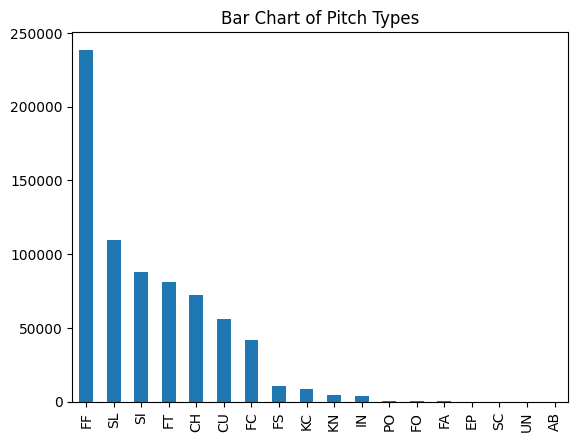

In [9]:
pitchtype_counts = pitch_data['pitch_type'].value_counts()
pitchtype_counts.plot(kind='bar', title='Bar Chart of Pitch Types')

I notice multiple types of fastballs so I will be encoding this later into one value "fastball" later.

Next, I'm going to extract the month from the data column, then drop the data column from the data

In [10]:
pitch_data['month'] = pitch_data['date'].apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d').month)
pitch_data.head()
pitch_data.drop('date', axis=1, inplace=True)

In [11]:
pitch_data['month'].value_counts()

5     122146
8     121887
9     117093
6     114961
4     114350
7     113972
10     10494
3       1778
Name: month, dtype: int64

Next, I'm converting the players on base to boolean since they are currently just a playerID

In [12]:
pitch_data['on_1b'] = pitch_data['on_1b'].apply(lambda x: not np.isnan(x))
pitch_data['on_2b'] = pitch_data['on_2b'].apply(lambda x: not np.isnan(x))
pitch_data['on_3b'] = pitch_data['on_3b'].apply(lambda x: not np.isnan(x))

Next, I'm creating a variable to see if the batter is batting from the same side the pitcher is pitching from

In [13]:
pitch_data['stand_pitch_same_side'] = pitch_data['p_throws'] == pitch_data['stand'] 
pitch_data.drop(['p_throws', 'stand'], axis=1, inplace=True)

Next, I'm creating a unique ID to help with a groupby, to know if the pitcher is pitching in the same game

In [14]:
pitch_data['game_pitcher_id'] = pitch_data['game_pk'].astype(str) + '_' + pitch_data['pitcher_id'].astype(str)
pitch_data.drop('game_pk', axis=1, inplace=True)

Next I'm creating a previous pitch type column

In [15]:
 pitch_data['prev_pitch_type'] = pitch_data.groupby('game_pitcher_id')['pitch_type'].apply(lambda x: x.shift(1))

Next I'm creating a previous pitch outcome column

In [16]:
pitch_data['prev_pitch_outcome'] = pitch_data.groupby('game_pitcher_id')['type'].apply(lambda x: x.shift(1))
pitch_data.drop('type', axis=1, inplace=True)

Verifying that the code is working correctly

In [17]:
test = pitch_data[(pitch_data.pitcher_id == 450308)]
#test.head(n=150)
#Code looks good

Getting previous zone position

In [18]:
pitch_data['prev_zone'] = pitch_data.groupby('game_pitcher_id')['zone'].apply(lambda x: x.shift(1))
pitch_data.drop('zone', axis=1, inplace=True)

Getting previous break length

In [19]:
pitch_data['prev_break_length'] = pitch_data.groupby('game_pitcher_id')['break_length'].apply(lambda x: x.shift(1))
pitch_data.drop('break_length', axis=1, inplace=True)

Getting previous break angle

In [20]:
pitch_data['prev_break_angle'] = pitch_data.groupby('game_pitcher_id')['break_angle'].apply(lambda x: x.shift(1))
pitch_data.drop('break_angle', axis=1, inplace=True)

Getting previous pitch velocity

In [21]:
pitch_data['prev_pitch_velocity'] = pitch_data.groupby('game_pitcher_id')['vy0'].apply(lambda x: x.shift(1))
pitch_data.drop('vy0', axis=1, inplace=True)

Filling NA's from previous columns with unknown character "UN"

In [22]:
pitch_data['prev_pitch_type'].fillna('UN', inplace=True)
pitch_data['prev_pitch_outcome'].fillna('UN', inplace=True)

Going to drop pitch types with any uknown pitches, pitchouts or ab's

---



In [23]:
pitchout_unknown_pitches = ['PO', 'FO', 'UN', 'XX', 'IN','AB']
pitch_data = pitch_data[~pitch_data['pitch_type'].isin(pitchout_unknown_pitches)]
pitch_data = pitch_data[~pitch_data['prev_pitch_type'].isin(pitchout_unknown_pitches)]

In [24]:
pitch_data.prev_pitch_outcome.unique()
#no UN variables

array(['S', 'B', 'X'], dtype=object)

Creating a fastball feature that takes all the fastball types and making it into one

In [25]:
fastball_pitches = ['FA', 'FF', 'FT', 'FC', 'FS', 'SI', 'SF']
#####
def fastballs(x):
        if x in fastball_pitches:
            return 'FB'
        else:
            return x
#####
pitch_data['pitch_type'] = pitch_data['pitch_type'].apply(fastballs)
pitch_data['prev_pitch_type'] = pitch_data['prev_pitch_type'].apply(fastballs)


Making previous pitch outcomes into integers, Ball = 0, Strike = 1, and in-play = 2

In [26]:
def pitch_outcome(x):
        if x == 'B':
            return 0
        elif x == 'S':
            return 1
        else:
            return 2
pitch_data['prev_pitch_outcome'] = pitch_data['prev_pitch_outcome'].apply(pitch_outcome)

Making height into inches

In [27]:
def convert_feet_inches_to_inches(height_string):
  match = re.match(r"(\d+)-(\d+)", height_string)
  if not match:
    raise ValueError("Invalid height string: {}".format(height_string))

  feet = int(match.group(1))
  inches = int(match.group(2))

  return feet * 12 + inches

pitch_data['batter_height'] = pitch_data['b_height'].apply(convert_feet_inches_to_inches)
pitch_data.drop('b_height', axis=1, inplace=True)

Making sure distribution of heights looks normal

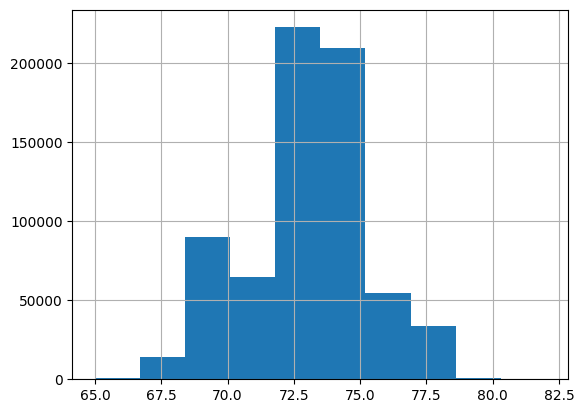

In [28]:
pitch_data['batter_height'].hist()
plt.show()

In [29]:
pitch_data['batter_height'].value_counts()

74    130340
72    115003
73    107743
75     79412
71     64962
70     61197
76     54380
69     28530
77     23413
68     13808
78     10220
66       818
79       575
80       227
65        51
67        45
82        40
81        13
Name: batter_height, dtype: int64

Given that the shortest player in the 2011 season was Jose Altuve at 66 inches, I'm going to remove all observations below that. I'm also going to remove observations of batters taller than 80 inches since there are significantly less at bats for those players.

In [30]:
pitch_data.shape

(690777, 23)

In [31]:
pitch_data = pitch_data[pitch_data['batter_height'] > 65] 

In [32]:
pitch_data = pitch_data[pitch_data['batter_height'] < 81] 

In [33]:
pitch_data.shape

(690673, 23)

In [34]:
pitch_data['batter_height'].value_counts()

74    130340
72    115003
73    107743
75     79412
71     64962
70     61197
76     54380
69     28530
77     23413
68     13808
78     10220
66       818
79       575
80       227
67        45
Name: batter_height, dtype: int64

Converting Pitch Velocity into MPH

In [35]:
pitch_data['prev_pitch_velocity'] = round(-pitch_data['prev_pitch_velocity'] * (3600 / 5280), 0)

Looking at distribution of pitch velocity

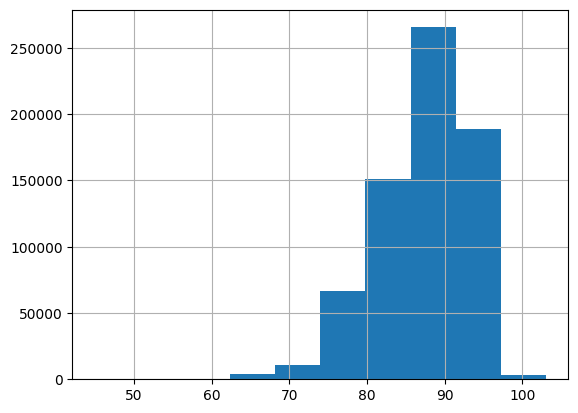

In [36]:
pitch_data['prev_pitch_velocity'].hist()
plt.show()

In [37]:
pitch_data['prev_pitch_velocity'].value_counts()

92.0     60917
91.0     60438
90.0     53430
93.0     52507
89.0     46247
88.0     39665
94.0     36822
87.0     34467
86.0     31245
85.0     30284
84.0     28897
83.0     27228
82.0     23980
81.0     21513
95.0     21402
80.0     19320
79.0     17109
78.0     14526
77.0     12211
96.0     11444
76.0      9841
75.0      7565
74.0      5549
97.0      5515
73.0      3816
72.0      2716
98.0      2326
71.0      1789
70.0      1339
66.0      1158
69.0      1079
67.0       991
68.0       904
99.0       840
65.0       684
100.0      266
64.0       217
61.0        80
63.0        73
101.0       65
60.0        63
62.0        62
59.0        37
102.0       16
58.0        12
57.0         6
56.0         4
55.0         2
54.0         2
103.0        1
45.0         1
53.0         1
46.0         1
Name: prev_pitch_velocity, dtype: int64

Seeing the distribution of the speed of the pitches I'm going to remove all previous pitch velocities that are under 64 mph. However I'm going to keep all values above that since there are some outliers above the 100 mph mark but they dont differ too much from 100, since the highest pitch was 103 mph.

In [38]:
pitch_data = pitch_data[pitch_data['prev_pitch_velocity'] > 63] 

In [39]:
pitch_data.shape

(690329, 23)

Filling missing previous pitch velocity with pitcher's mean velocity


In [40]:
pitch_data["prev_pitch_velocity"] = pitch_data.groupby("game_pitcher_id")["prev_pitch_velocity"].transform(lambda x: x.fillna(x.mean()))

Selecting and organizing final variables of the model

In [41]:
pitch_data = pitch_data[['pitcher_id', 'pitch_type', 'inning', 'top', 'pcount_at_bat', 'pcount_pitcher', 
             'balls', 'strikes', 'fouls', 'outs', 'on_1b', 'on_2b', 'on_3b', 'month', 
             'stand_pitch_same_side', 'prev_pitch_type', 
             'prev_pitch_outcome', 'prev_zone', 'prev_break_length', 'prev_break_angle', 
             'prev_pitch_velocity', 'batter_height']]

In [42]:
pitch_data.prev_pitch_type.unique()

array(['FB', 'SL', 'CU', 'KC', 'CH', 'KN', 'EP', 'SC'], dtype=object)

Looking at new distribution of target variable pitch type

<Axes: title={'center': 'Bar Chart of Pitch Types'}>

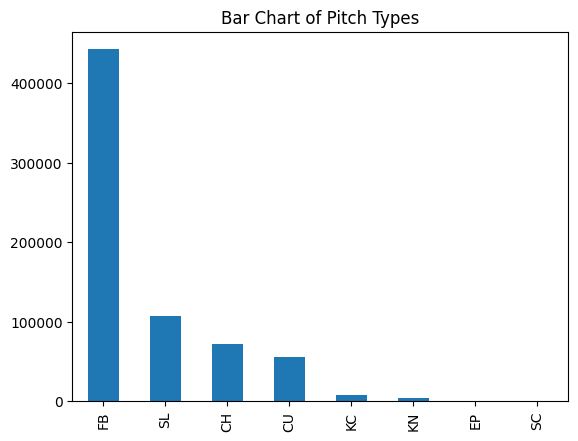

In [43]:
pitchtype_counts = pitch_data['pitch_type'].value_counts()
pitchtype_counts.plot(kind='bar', title='Bar Chart of Pitch Types')

In [44]:
pitch_data['pitch_type'].value_counts()

FB    442831
SL    107082
CH     71989
CU     55629
KC      8345
KN      4204
EP       133
SC       116
Name: pitch_type, dtype: int64

Looking at pitch counts for each pitcher

In [45]:
pitch_data['pitcher_id'].value_counts().mean()
#the mean of the total pitches for a pitcher is 1042

1042.7930513595165

In [46]:
np.quantile(pitch_data['pitcher_id'].value_counts(), 0.25)
#the first quartile of the total pitchers for a pitcher is 241

241.0

Since the middle between the mean and the first quartile is around 640 for total pitches per pitcher I'm going round this to 600 and use this as the cutoff for the pitchers we will keep in the dataset

In [47]:
pitch_data['pitcher_id'].value_counts()

434378    4234
112020    4075
450351    4049
456034    3736
451596    3721
450308    3703
429717    3701
282332    3699
448306    3640
136880    3640
453286    3583
453178    3582
433587    3562
407890    3560
502706    3552
453311    3537
150116    3499
543339    3489
429719    3476
424324    3468
450729    3428
430912    3428
133225    3422
477132    3419
475416    3384
429722    3383
461829    3366
134321    3344
502239    3335
457448    3315
448802    3312
460069    3308
451788    3295
408206    3289
425386    3247
434578    3218
150359    3218
450306    3197
430935    3196
434622    3195
117955    3166
451532    3161
434671    3154
218596    3146
452657    3145
493133    3143
460059    3137
490063    3133
518516    3131
468504    3102
279824    3100
434643    3083
502009    3083
445060    3071
425844    3071
502032    3070
453344    3069
276520    3031
460024    3030
285079    3029
519144    3025
150414    2997
346798    2991
433584    2960
207267    2956
277417    2950
431162    

In [48]:
pitcher_count_dict = dict(Counter(pitch_data['pitcher_id']))

In [49]:
len(pitcher_count_dict)

662

Getting ID's of pitcher's with over 600 or more pitches

In [50]:
pitcher_count_dict = {k:v for k, v in pitcher_count_dict.items() if v > 600}
pitcher_list = pitcher_count_dict.keys()

In [51]:
len(pitcher_count_dict)
#292 pitchers were removed from the data

370

In [52]:
pitch_data = pitch_data[pitch_data['pitcher_id'].isin(pitcher_list)]

In [53]:
pitch_data.shape

(619160, 22)

In [54]:
pitch_data.pitch_type.value_counts()

FB    397709
SL     92627
CH     65957
CU     50650
KC      7847
KN      4188
EP       130
SC        52
Name: pitch_type, dtype: int64

In [55]:
remove_pitch_types = ['EP', 'SC']
pitch_data = pitch_data[~pitch_data['pitch_type'].isin(remove_pitch_types)]
pitch_data = pitch_data[~pitch_data['prev_pitch_type'].isin(remove_pitch_types)]

In [56]:
pitch_data.pitch_type.value_counts()

FB    397656
SL     92615
CH     65951
CU     50638
KC      7847
KN      4169
Name: pitch_type, dtype: int64

Since there are such little observations of EP and SC I'm going to remove those from the data as well. I'm going to look at this for pitchers as a whole given the time constraint, so when using this particular model the only types of pitches that will be observed for any given pitcher would be FB, SL, CH, CU, KC, and KN

In [57]:
pitch_data.shape

(618876, 22)

## **Building Model**

I'm now going to begin the model building process. I plan on using a XGboost model.

In [58]:
pitch_data.columns

Index(['pitcher_id', 'pitch_type', 'inning', 'top', 'pcount_at_bat',
       'pcount_pitcher', 'balls', 'strikes', 'fouls', 'outs', 'on_1b', 'on_2b',
       'on_3b', 'month', 'stand_pitch_same_side', 'prev_pitch_type',
       'prev_pitch_outcome', 'prev_zone', 'prev_break_length',
       'prev_break_angle', 'prev_pitch_velocity', 'batter_height'],
      dtype='object')

I'm going to drop the pitcher_id columns since I don't want the model to train on the pitcher

In [59]:
pitch_data = pitch_data.drop('pitcher_id', axis=1)

In [60]:
pitch_data.columns

Index(['pitch_type', 'inning', 'top', 'pcount_at_bat', 'pcount_pitcher',
       'balls', 'strikes', 'fouls', 'outs', 'on_1b', 'on_2b', 'on_3b', 'month',
       'stand_pitch_same_side', 'prev_pitch_type', 'prev_pitch_outcome',
       'prev_zone', 'prev_break_length', 'prev_break_angle',
       'prev_pitch_velocity', 'batter_height'],
      dtype='object')

Starting to build first XGboost model

In [61]:
X, y = pitch_data.drop("pitch_type", axis=1), pitch_data[['pitch_type']]

# Encode y to numeric
y_encoded = OrdinalEncoder().fit_transform(y)

# Extract text features
cats = X.select_dtypes(exclude=np.number).columns.tolist()

# Convert to pd.Categorical
for col in cats:
   X[col] = X[col].astype('category')

# Split the data 70/30
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, random_state=49127, stratify=y_encoded, test_size = .3)

In [62]:
# Create classification matrices
dtrain_clf = xgb.DMatrix(X_train,label =  y_train, enable_categorical=True)
dtest_clf = xgb.DMatrix(X_test, label = y_test, enable_categorical=True)

In [63]:
#model
params = {"objective": "multi:softprob", "num_class": 6}
n = 10
results = xgb.cv(
   params, dtrain_clf,
   num_boost_round=n,
   nfold=3,
   metrics=["mlogloss", "auc", "merror"],
)

In [64]:
#getting best iteration from the results
best_iteration = results['test-auc-mean'].idxmin()
results['test-auc-mean'].max()

0.6724185861093175

In [65]:
# Train the model on the entire training dataset
model = xgb.train(params=params, dtrain=dtrain_clf, num_boost_round=best_iteration)

# Predict the labels of the test dataset
predictions = model.predict(dtest_clf)

In [66]:
best_preds = np.asarray([np.argmax(line) for line in predictions])
#print(precision_score(y_test, best_preds, average="macro"))
print(accuracy_score(y_test, best_preds))

0.10656404345507721


Next instead of using xgb.cv I'm going to attempt using XGBclassifier instead with cross validation

In [67]:
xgb_params = {"max_depth": (2, 3, 5),
                      "learning_rate": (0.01, 0.1, 0.4)}

xgb_opt = GridSearchCV(XGBClassifier(objective='multi:softprob', num_class=6, enable_categorical=True, tree_method="hist"), 
                               param_grid=xgb_params, cv=5, scoring='accuracy', verbose=0, n_jobs=-1)

Fitting the model and making predictions

In [ ]:
xgb_opt.fit(X_train, y_train)

In [69]:
y_pred = xgb_opt.predict(X_test)
y_prob = xgb_opt.predict_proba(X_test)

In [70]:
accuracy_score(y_test, y_pred)

0.648718376844067

In [71]:
roc_auc_score(y_test, y_prob, multi_class='ovr')

0.7718236019296754

## The model using the hist tree method (second model) did a much better job according to the accuracy and auc score when compared to the first model. The first model seems to be underfitting due to the fact it only went through 10 rounds. If I had more time and a gpu ready to use I would have increased the rounds and folds of both models to get more accurate models.

## **Next Steps:**

The next steps for this project would be to actually implement this model with real-time data or you could even make an app that lets you input the predictors to give the probabilities of what the next pitch type would be or even just guess which pitch it would be given the highest probability.

If I had more time and resources I would have loved to expanded the model much more. I only used depths of 2,3, and 5 for the second model because any larger depths would have made this code run for a long time. I also wanted to test out the tree method "gpu_hist", but unfortunatley I do not have a gpu set up.

I also would have loved to create more features such as going back to even more previous pitch types, rather than just the last pitch thrown. Also if there was a weather variable, I would have liked to use that as well. As well as somehow implementing the specified pitcher's pitches to the model in order for the model to know to only look at and make probabilities for the specified pitcher's pitches.

Building off this last point I would have liked to do a more fleshed out analysis of the different features instead of just going off prior knowledge of baseball and what I thought would be good predictors of pitch_type. Something I would have like to have done is a feature importance plot or a correlation matrix with all the variables and pitch_type to see which features truly are the best predictors of pitch_type.

Another thing I would have liked to have done is to test different models besides XGboost and use even more cross validation folds to see which model and it's hyperparemeters really make the optimal model.

Lastly, having the most up to date data would have been nice to see as well, since the game is constantly changing, so having more seasons to train on would be nice to have as well.